In [ ]:
#@title Imports
!pip install brian2
!pip install ipython-autotime
%load_ext autotime

from brian2 import *

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm

import types
from scipy import signal

tf.random.set_seed(42)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.1 MB/s eta 0:00:00
time: 11.1 s (started: 2023-09-21 10:37:00 +00:00)


In [ ]:
#@title Plot parameteres
#Ustawiam domyślne wielkości wykresów
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 100
#plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.linestyle": '--', "grid.linewidth": 0.5 })
plt.subplots_adjust(top = 1, bottom = 0.5, wspace=2, hspace=4)

NameError: name 'plt' is not defined

In [ ]:
#@title Hodgkin-Huxley model function

def calculate_HH_model_response(input_func, t_in_ms, mode='single'):
  start_scope()

  if isinstance(input_func, types.FunctionType):
    t_recorded = arange(int(t_in_ms*ms/defaultclock.dt))*defaultclock.dt/ms
    I_recorded = TimedArray(np.random.uniform(low=0, high=0.9)*500000*input_func(np.random.uniform(low=0.5, high=0.9)  * t_recorded), dt=defaultclock.dt)

  elif isinstance(input_func, np.ndarray):
    I_recorded = TimedArray(input_func, dt=defaultclock.dt)


  #area = 20000 * umetre**2
  #Cm = 1 * nfarad * cm**-2 * area
  #gl = 5e-5 * siemens * cm**-2 * area
  #El = -65 * mV
  #EK = -90 * mV
  #ENa = 50 * mV
  #g_na = 100 * msiemens * cm**-2 * area
  #g_kd = 30 * msiemens * cm**-2 * area
  #VT = -63 * mV

  #g_na = 120 * msiemens #* cm**-2 #* area
  #g_kd = 36 * msiemens #* cm**-2 #* area
  #gl = 0.3 * msiemens #* cm**-2 #* area
  #El = -54.4 * mV
  #EK = -77 * mV
  #ENa = 50 * mV

  #VRest = -65 * mV

  tresh = -40 * mV
  refrac = 3 * ms

  E_synap = -75 * mV
  conduct = 40 * nS

  Cm = 1 * uF  # Membrane capacitance
  g_na = 120 * msiemens  # Sodium conductance
  g_kd = 36 * msiemens  # Potassium conductance
  gl = 0.3 * msiemens  # Leak conductance
  ENa = 50 * mV  # Sodium reversal potential
  EK = -77 * mV  # Potassium reversal potential
  El = -54.4 * mV  # Leak reversal potential
  VRest = -65 * mV  # Resting membrane potential

  eqs_HH = '''
  dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm * second: volt
  dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/(exp((13.*mV-v+VT)/(4.*mV))-1.)*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/(exp((v-VT-40.*mV)/(5.*mV))-1.)*m : 1
  dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/(exp((15.*mV-v+VT)/(5.*mV))-1.)*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))*n : 1
  dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))*h : 1
  I = I_recorded(t) * nA: amp
  '''

  eqs_HH_old = '''
  dv/dt = (g_na*(m*m*m)*(ENa-v) + g_kd*(n*n*n*n)*(EK-v) + gl*(El-v) + I)/Cm : volt
  dm/dt = ((0.1*(mV**-1.) * (v-VRest-25.*mV)) / (1.-exp((-(v-VRest-25.*mV)/(10.*mV)))))*(1.-m) - m*4.*exp((-(v-VRest)/(18.*mV))) : 1
  dn/dt = ((0.01*(mV**-1.)*(v-VRest-10.*mV)) / (1.-exp((-(v-VRest-10.*mV)/(10.*mV)))))*(1.-n) - n*0.125*exp((-(v-VRest)/(80.*mV))) : 1
  dh/dt = (0.07 * exp((-(v-VRest)/(20.*mV)))) * (1.-h) - h * ( 1. / (1.+exp((-(v-VRest-35.*mV)/(10.*mV))))) : 1
  I = I_recorded(t) * nA: amp
  '''
  #dh/dt = ((0.07 * exp((-(v-VRest)/(20.*mV)))) * (1.-h)) - (h * ( 1. / (1.+exp((-(v-VRest-35.*mV)/(10.*mV)))))) : 1
  eqs_HH_post_old = '''
  dv/dt = (g_na*(m*m*m)*h*(ENa-v) + g_kd*(n*n*n*n)*(EK-v) + gl*(El-v) + I)/Cm : volt
  dm/dt = (0.1*(mV**-1.)*(v-VRest-25.*mV)/(1.-exp(-(v-VRest-25.*mV)/(10.*mV))))*(1.-m) - (m*4.*exp(-(v-VRest)/18.*mV)) : 1
  dn/dt = ((0.01*(mV**-1.)*(v-VRest-10.*mV))/(1.-exp(-(v-VRest-10.*mV)/(10.*mV))))*(1.-n) - (0.125*exp(-(v-VRest)/80.*mV)) : 1
  dh/dt = (0.07*exp((-(v-VRest)/(20.*mV))))*(1.-h) - (h*(1./(1.+exp(-(v-VRest-30.*mV)/(10.*mV)))))) : 1
  I : amp
  '''
  neuron_eqs = '''
  dv/dt = (1/Cm) * (I_Na + I_K + I_L + I) : volt
  I_Na = g_na * m**3 * h * (ENa - v) : amp
  I_K = g_kd * n**4 * (EK - v) : amp
  I_L = gl * (El - v) : amp
  dm/dt = (alpha_m * (1 - m) - beta_m * m) : 1
  dn/dt = (alpha_n * (1 - n) - beta_n * n) : 1
  dh/dt = (alpha_h * (1 - h) - beta_h * h) : 1
  alpha_m = (0.1/mV) * (10*mV) / exprel((v + 25*mV) / (10*mV))/ms : Hz
  beta_m = 4 * exp((v + 50*mV) / (18*mV))/ms : Hz
  alpha_n = (0.01/mV) * (10*mV) / exprel((v + 10*mV) / (10*mV))/ms : Hz
  beta_n = 0.125 * exp(v / (80*mV))/ms : Hz
  alpha_h = 0.07 * exp(v / (20*mV))/ms : Hz
  beta_h = 1 / (exp((v + 30*mV) / (10*mV)) + 1)/ms : Hz
  I = I_recorded(t) * nA: amp
  '''
  eqs_HH_post = '''
  dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
  dm/dt = 0.32*(mV**-1)*(13.*mV-v+VT)/
      (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
      (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
  dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
      (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
  dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
  I : amp
  '''

  group0 = NeuronGroup(1,
                       neuron_eqs,
                       threshold='v > tresh',
                       refractory=refrac,
                       method='exponential_euler')

  stm0 = StateMonitor(group0, variables=True, record=True)

  if mode == 'synapse':
    group1 = NeuronGroup(1, eqs_HH_post,
                        threshold='v > tresh',
                        refractory=refrac,
                        method='exponential_euler')

    S = Synapses(group0, group1, '''
                w : siemens (constant) # gap junction conductance
                I_post = w * (v_pre - E_synap) : amp (summed)
                ''')
    S.connect(i=[0], j=[0])
    S.w = conduct

    stm1 = StateMonitor(group1, variables=True, record=True)

  run(t_in_ms*ms)

  if mode == 'single': # /mV /nA
    return np.array(stm0.v[0]/mV), np.array(stm0.m[0]), np.array(stm0.n[0]), np.array(stm0.h[0]), np.array(stm0.I[0]/nA), np.array(stm0.t/ms)

  elif mode == 'synapse':
    return np.array(stm0.v[0]/mV), np.array(stm0.h[0]), np.array(stm0.I[0]/nA), np.array(stm1.v[0]/mV), np.array(stm1.h[0]), np.array(stm1.I[0]/nA), np.array(stm0.t/ms)

  elif mode == 'single-response':
    return np.array(stm0.v[0]/mV), np.array(stm0.m[0]), np.array(stm0.n[0]), np.array(stm0.h[0]), np.array(stm0.t/ms)


time: 15.4 ms (started: 2023-09-21 10:39:15 +00:00)


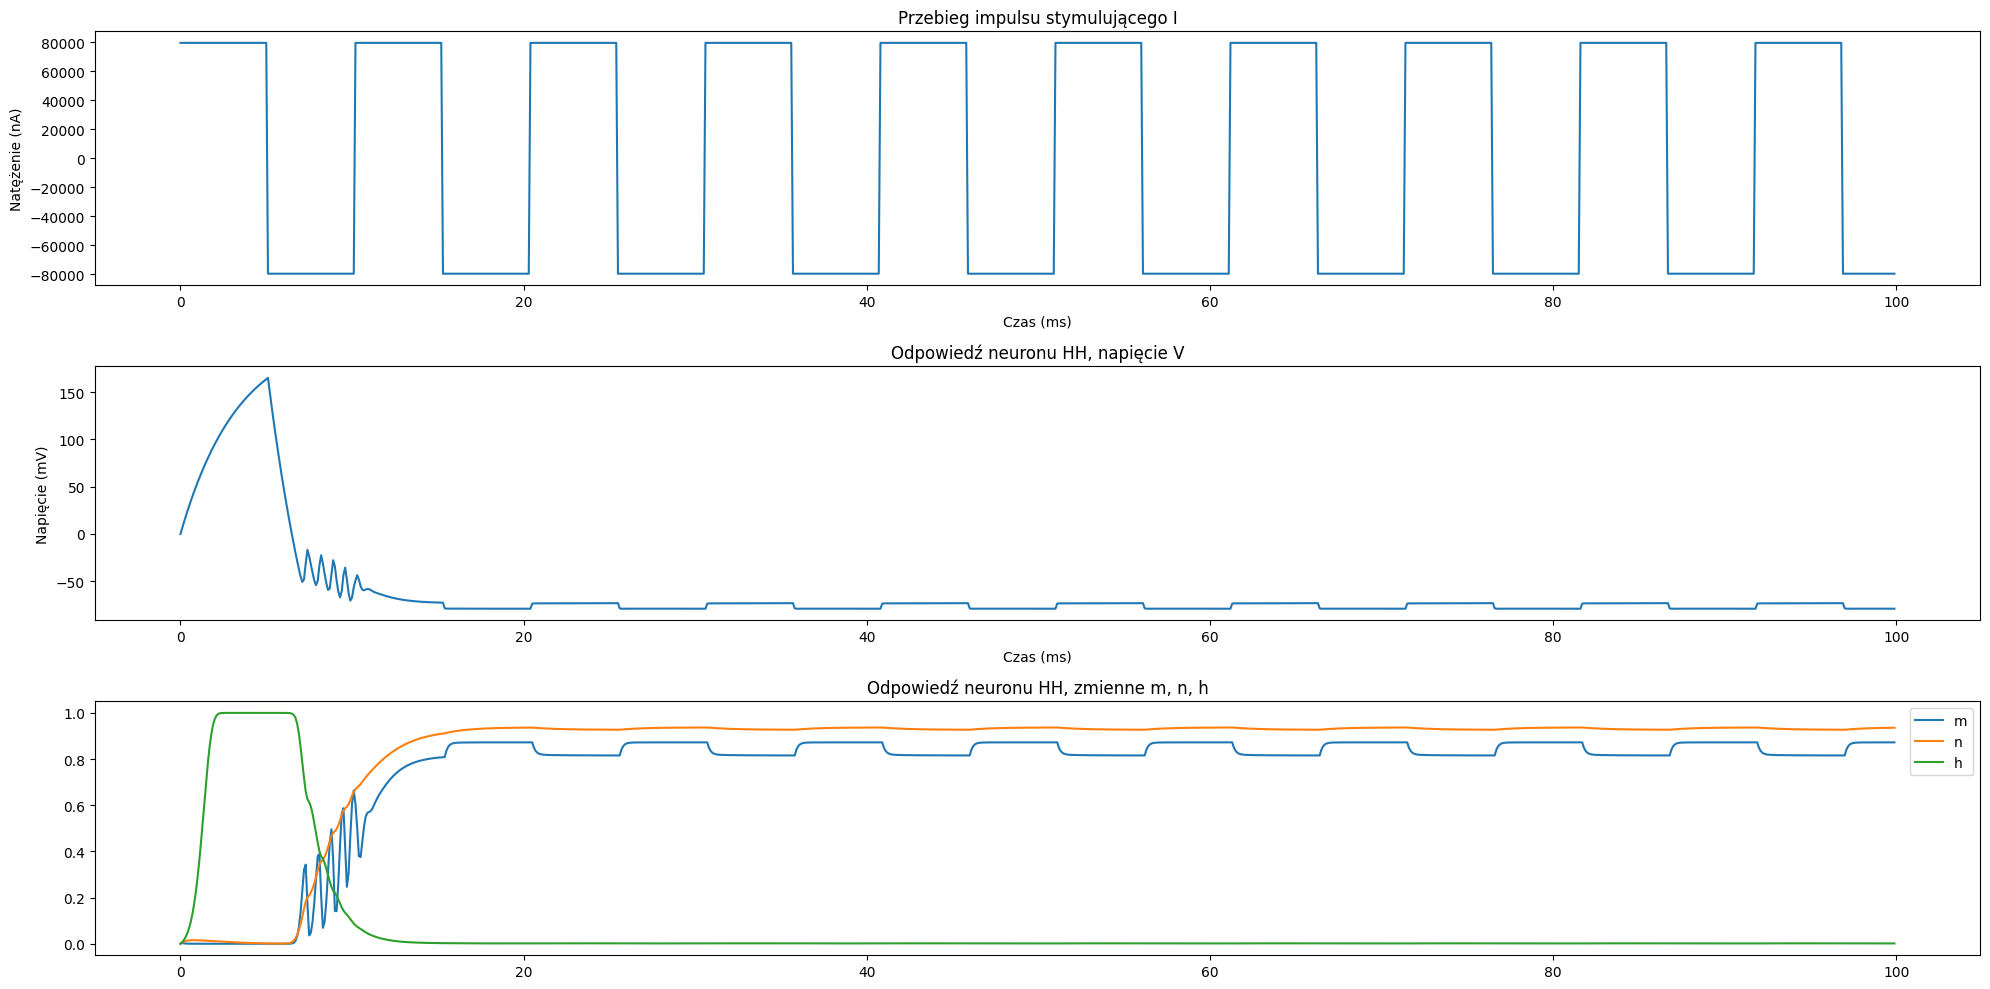

In [ ]:
#@title Testing the Hodgkin-Huxley model function
v_single, m_single, n_single, h_single, i_single, t_single = calculate_HH_model_response(signal.square, 100)

plt.subplot(3, 1, 1)
plt.plot(t_single, i_single)
plt.title('Przebieg impulsu stymulującego I')
plt.xlabel('Czas (ms)')
plt.ylabel('Natężenie (nA)')
plt.subplot(3, 1, 2)
plt.plot(t_single, v_single)
plt.title('Odpowiedź neuronu HH, napięcie V')
plt.xlabel('Czas (ms)')
plt.ylabel('Napięcie (mV)')
plt.subplot(3, 1, 3)
plt.plot(t_single, m_single, label='m')
plt.plot(t_single, n_single, label='n')
plt.plot(t_single, h_single, label='h')
plt.title('Odpowiedź neuronu HH, zmienne m, n, h')
plt.legend()
plt.tight_layout()
plt.savefig("single-neuron-simulation.png")

In [ ]:
def generate_lif_responses():

In [ ]:
#@title Helper functions for solving HH equations
@tf.function
def alfa_n(v):
  return (0.01 * (10 - v)) / tf.math.exp((10-v)/10) - 1

@tf.function
def alfa_h(v):
  return 0.07 * tf.math.exp(-v/20)

@tf.function
def alfa_m(v):
  return (0.1 * (25 - v)) / tf.math.exp((25-v)/10) - 1

@tf.function
def beta_n(v):
  return 0.125 * tf.math.exp(-v/80)

@tf.function
def beta_h(v):
  return 1 / tf.math.exp((30-v)/10) + 1

@tf.function
def beta_m(v):
  return 4.0 * tf.math.exp(-v/18)

@tf.function
def I_na(v, m, h):
  return constant_dict.get('g_na') * tf.math.pow(m, 3) * h * (constant_dict.get('v_na') - v)

@tf.function
def I_k(v, n):
  return constant_dict.get('g_k') * tf.math.pow(n, 4) * (constant_dict.get('v_k') - v)

@tf.function
def I_L(v):
  return constant_dict.get('g_l') * (constant_dict.get('v_l') - v)

time: 5.34 ms (started: 2023-09-14 02:19:31 +00:00)


Text(0.5, 1.0, 'output V, target')

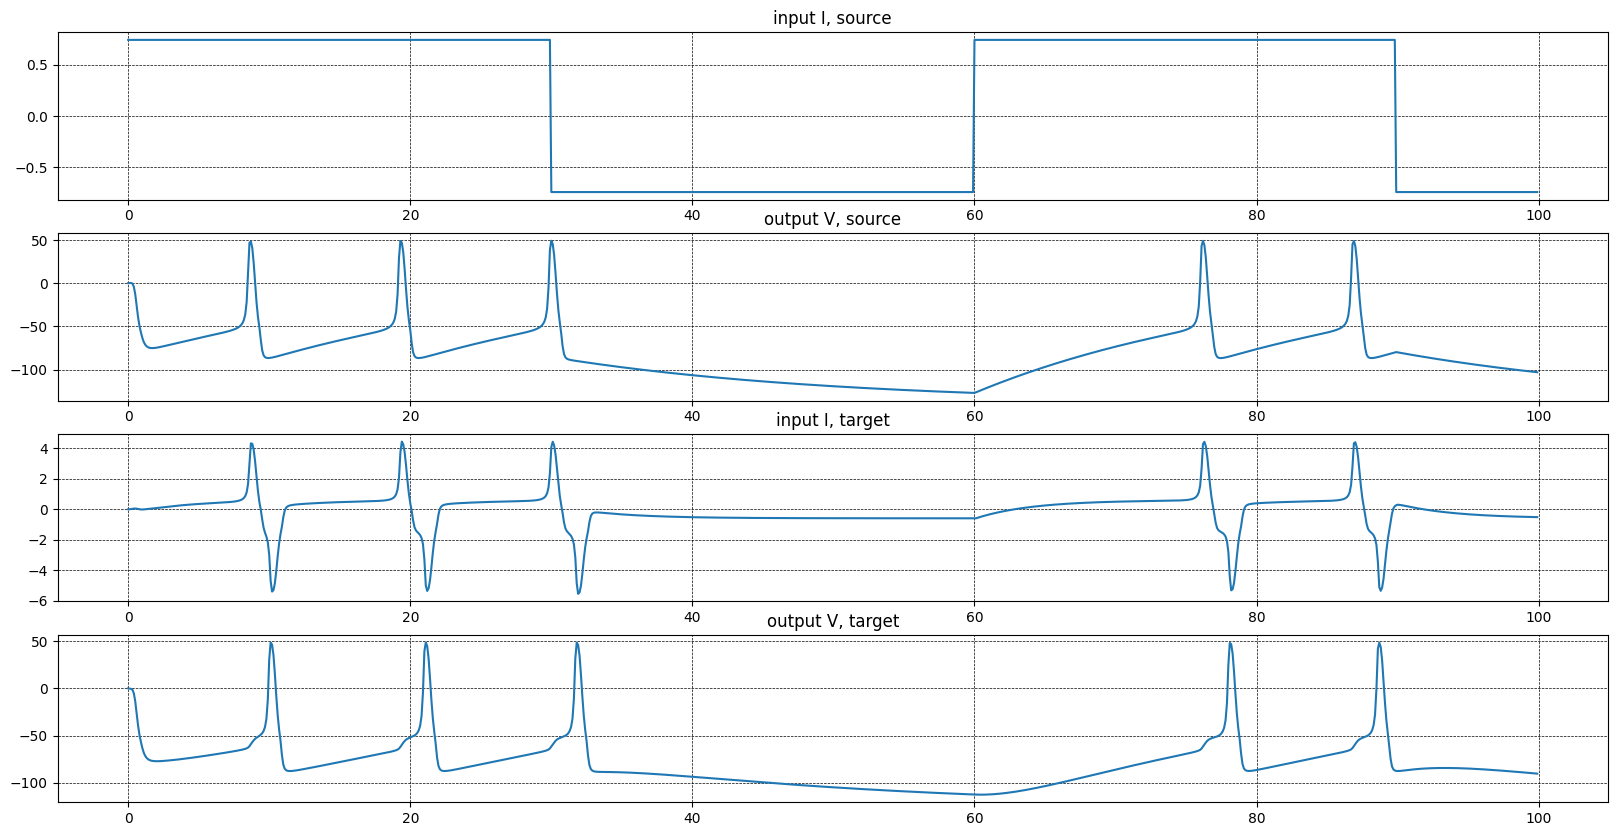

time: 1.6 s (started: 2023-09-07 00:01:08 +00:00)


In [ ]:
#@title Testing the Hodgkin-Huxley model function
v_source_output, h_source_output, i_source_input, v_target_output, h_target_output, i_target_input, t_source = calculate_HH_model_response(signal.square, 100, mode='synapse')

plt.subplot(4, 1, 1)
plt.plot(t_source, i_source_input)
plt.title('input I, source')

plt.subplot(4, 1, 2)
plt.plot(t_source, v_source_output)
plt.title('output V, source')

plt.subplot(4, 1, 3)
plt.plot(t_source, i_target_input)
plt.title('input I, target')

plt.subplot(4, 1, 4)
plt.plot(t_source, v_target_output)
plt.title('output V, target')

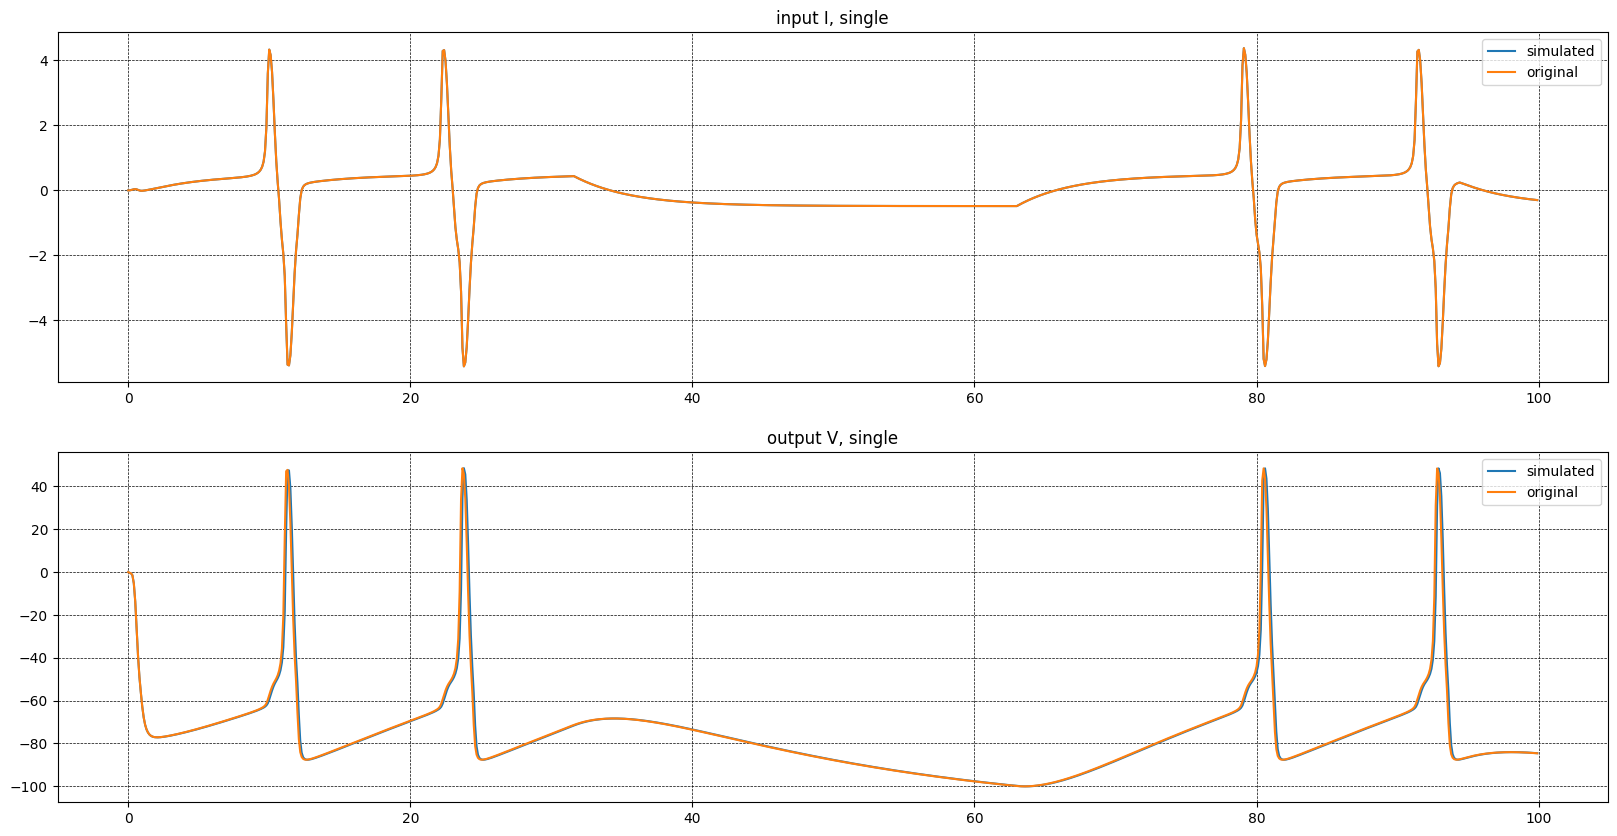

time: 3.92 s (started: 2023-09-06 23:35:11 +00:00)


In [ ]:
#@title Testing the Hodgkin-Huxley model function
v_single, m_single, n_single, h_single, i_single, t_single = calculate_HH_model_response(i_target_input, 100)

plt.subplot(2, 1, 1)
plt.plot(t_single, i_single, label='simulated')
plt.plot(t_source, i_target_input, label='original')
plt.title('input I, single')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t_single, v_single, label='simulated')
plt.plot(t_source, v_target_output, label='original')
plt.title('output V, single')
plt.legend()

In [ ]:
#@title Generating training and test datasets

def generate_dataset(N_samples, t_in_ms, N_t_samples, synaptic=False):
  generated_inputs = np.zeros((N_samples, t_in_ms * 10))
  generated_t_inputs = np.zeros((N_samples, t_in_ms * 10))

  generated_v_responses = np.zeros((N_samples, t_in_ms * 10))
  generated_m_responses = np.zeros((N_samples, t_in_ms * 10))
  generated_n_responses = np.zeros((N_samples, t_in_ms * 10))
  generated_h_responses = np.zeros((N_samples, t_in_ms * 10))
  generated_i_responses = np.zeros((N_samples, t_in_ms * 10))
  generated_t_responses = np.zeros((N_samples, t_in_ms * 10))

  for i in range(N_samples//2):
    _, _, _, _, _, generated_inputs[i, :], generated_t_inputs[i, :] = calculate_HH_model_response(signal.square, t_in_ms, mode='synapse')
    generated_v_responses[i, :], generated_m_responses[i, :], generated_n_responses[i, :], generated_h_responses[i, :], generated_i_responses[i, :], generated_t_responses[i, :] = calculate_HH_model_response(generated_inputs[i, :], t_in_ms)

  if synaptic == True:
    for u in range(N_samples//2, N_samples):
      generated_inputs[u, :] = np.random.uniform(low=0, high=0.9) * signal.square(np.random.uniform(low=0.05, high=0.2) * (np.pi / 2) * generated_t_responses[0, :])
      generated_t_inputs[u, :] = generated_t_responses[0, :]
      generated_v_responses[u, :], generated_m_responses[u, :], generated_n_responses[u, :], generated_h_responses[u, :], generated_i_responses[u, :], generated_t_responses[u, :] = calculate_HH_model_response(generated_inputs[u, :], t_in_ms)
  else:
    for u in range(N_samples//2):
      _, _, _, _, _, generated_inputs[u, :], generated_t_inputs[u, :] = calculate_HH_model_response(signal.square, t_in_ms, mode='synapse')
      generated_v_responses[u, :], generated_m_responses[u, :], generated_n_responses[u, :], generated_h_responses[u, :], generated_i_responses[u, :], generated_t_responses[u, :] = calculate_HH_model_response(generated_inputs[u, :], t_in_ms)

  X = np.zeros((N_samples*N_t_samples, t_in_ms * 10 + 2))
  y = np.zeros((N_samples*N_t_samples, 4))
  t = generated_t_responses[0, :]

  id = -1
  for o in range(N_samples):
    for p in range(N_t_samples):
      if N_t_samples != t_in_ms*10:
        id = np.random.choice(range(len(t)))
      else:
        id += 1
      X[p+o*N_t_samples, : 1] = t[id]
      X[p+o*N_t_samples, 1 : t_in_ms * 10+1] = generated_inputs[o, :]
      X[p+o*N_t_samples, t_in_ms * 10+1 : t_in_ms * 10+2] = generated_inputs[o, id]
      y[p+o*N_t_samples, :] = generated_v_responses[o, id], generated_m_responses[o, id], generated_n_responses[o, id], generated_h_responses[o, id]

  shuffler = np.random.permutation(N_samples*N_t_samples)

  return X[shuffler, :], y[shuffler, :], t

X_train, y_train, t_train = generate_dataset(500, 100, 100)
X_val, y_val, t_val = generate_dataset(100, 100, 100)
X_test, y_test, t_test = generate_dataset(100, 100, 100)

np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('t_train.npy', t_train)

np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('t_val.npy', t_val)

np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
np.save('t_test.npy', t_test)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)
'''
plt.subplot(4, 1, 1)
plt.plot(generated_t_inputs[0, :], generated_inputs[0, :])
plt.title('input I (nA), neuronal response functions')

plt.subplot(4, 1, 2)
plt.plot(generated_t_responses[0, :], generated_v_responses[0, :])
plt.title('output V (mV), neuronal response functions')

plt.subplot(4, 1, 3)
plt.plot(generated_t_inputs[N//2, :], generated_inputs[N//2, :])
plt.title('input I (nA), square functions')

plt.subplot(4, 1, 4)
plt.plot(generated_t_responses[N//2, :], generated_v_responses[N//2, :])
plt.title('output V (mV), square functions')
'''

(50000, 1002)
(50000, 4)
(10000, 1002)
(10000, 4)
(10000, 1002)
(10000, 4)


"\nplt.subplot(4, 1, 1)\nplt.plot(generated_t_inputs[0, :], generated_inputs[0, :])\nplt.title('input I (nA), neuronal response functions')\n\nplt.subplot(4, 1, 2)\nplt.plot(generated_t_responses[0, :], generated_v_responses[0, :])\nplt.title('output V (mV), neuronal response functions')\n\nplt.subplot(4, 1, 3)\nplt.plot(generated_t_inputs[N//2, :], generated_inputs[N//2, :])\nplt.title('input I (nA), square functions')\n\nplt.subplot(4, 1, 4)\nplt.plot(generated_t_responses[N//2, :], generated_v_responses[N//2, :])\nplt.title('output V (mV), square functions')\n"

time: 14min 58s (started: 2023-09-14 02:19:31 +00:00)


In [ ]:
#@title Synapse definition
def synapse(v_pre):
  w = constant_dict.get('w')
  E_synap = constant_dict.get('e_synap')
  I = w * v_pre - E_synap
  return I

time: 1.32 ms (started: 2023-09-11 08:38:47 +00:00)


In [ ]:
'''
  area = 20000 * umetre**2
  Cm = 1 * ufarad * cm**-2 * area
  gl = 5e-5 * siemens * cm**-2 * area
  El = -65 * mV
  EK = -90 * mV
  ENa = 50 * mV
  g_na = 100 * msiemens * cm**-2 * area
  g_kd = 30 * msiemens * cm**-2 * area
  VT = -63 * mV
  tresh = -40 * mV
  refrac = 3 * ms
  E_synap = -75 * mV
  conduct = 40 * nS
'''

non_tf_constant_dict = {
    'Cm': 0.000001 * 2000 * 0.000001 * 0.000001 / 0.0001,
    'g_na': 100 * 0.001 * 2000 * 0.000001 * 0.000001 / 0.0001,
    'g_k': 30 * 0.001 * 2000 * 0.000001 * 0.000001 / 0.0001,
    'g_l': 0.00005 * 2000 * 0.000001 * 0.000001 / 0.0001,
    'v_na': 50 * 0.001,
    'v_k': -90 * 0.001,
    'v_l':  -65 * 0.001,
    'w': 40 * 0.000000001,
    'e_synap': -75 * 0.001,
}

constant_dict = {k: tf.constant(v, dtype=tf.float32) for k, v in non_tf_constant_dict.items()}

time: 96 ms (started: 2023-09-14 02:34:30 +00:00)


In [ ]:
#@title Defining model architecture

class BiasLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.bias = self.add_weight(shape=(4),
                                    initializer=tf.keras.initializers.Zeros(),
                                    trainable=True)
    def call(self, inputs):
        return inputs + self.bias

class Slice(keras.layers.Layer):
    def __init__(self, begin, size,**kwargs):
        super(Slice, self).__init__(**kwargs)
        self.begin = begin
        self.size = size

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'begin': self.begin,
            'size': self.size,
        })
        return config

    def call(self, inputs):
        return tf.slice(inputs, self.begin, self.size)

class Split(keras.layers.Layer):
    def __init__(self, num_or_size_splits, axis,**kwargs):
        super(Split, self).__init__(**kwargs)
        self.num_or_size_splits = num_or_size_splits
        self.axis = axis

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_or_size_splits': self.num_or_size_splits,
            'axis': self.axis,
        })
        return config

    def call(self, inputs):
        return tf.split(inputs, self.num_or_size_splits, self.axis)

def create_model(mean, var, verbose=False):
    """Definition of a DeepONet with fully connected branch and trunk layers.

    Args:
    ----
    mean: dictionary, mean values of the inputs
    var: dictionary, variance values of the inputs
    verbose: boolean, indicate whether to show the model summary

    Outputs:
    --------
    model: the DeepONet model
    """

    # Branch net
    branch_input = tf.keras.Input(shape=(len(mean['forcing'])), name="forcing")
    branch = tf.keras.layers.Normalization(mean=mean['forcing'], variance=var['forcing'])(branch_input)
    for i in range(4):
        branch = tf.keras.layers.Dense(200, activation="tanh", name='branch_'+str(i))(branch)

    # Trunk net
    trunk_input = tf.keras.Input(shape=(len(mean['time'])), name="time")
    trunk = tf.keras.layers.Normalization(mean=mean['time'], variance=var['time'])(trunk_input)
    for i in range(4):
        trunk = tf.keras.layers.Dense(200, activation="tanh", name='trunk_'+str(i))(trunk)

    # Compute the dot product between branch and trunk net
    '''
    dot_product_v = tf.reduce_sum(tf.multiply(branch[:50], trunk[:50]), axis=1, keepdims=True)
    dot_product_m = tf.reduce_sum(tf.multiply(branch[50:100], trunk[50:100]), axis=1, keepdims=True)
    dot_product_h = tf.reduce_sum(tf.multiply(branch[100:150], trunk[100:150]), axis=1, keepdims=True)
    dot_product_n = tf.reduce_sum(tf.multiply(branch[150:200], trunk[150:200]), axis=1, keepdims=True)
    '''
    '''slice_layer_v_branch = Slice([0, 0], [50])(branch)
    slice_layer_m_branch = Slice([50], [50])(branch)
    slice_layer_h_branch = Slice([100], [50])(branch)
    slice_layer_n_branch = Slice([150], [50])(branch)

    slice_layer_v_trunk = Slice([0], [50])(trunk)
    slice_layer_m_trunk = Slice([50], [50])(trunk)
    slice_layer_h_trunk = Slice([100], [50])(trunk)
    slice_layer_n_trunk = Slice([150], [50])(trunk)'''

    v_neurons_branch, m_neurons_branch, h_neurons_branch, n_neurons_branch = Split(4, axis=1)(branch)
    v_neurons_trunk, m_neurons_trunk, h_neurons_trunk, n_neurons_trunk = Split(4, axis=1)(trunk)

    dot_product_v = tf.keras.layers.Dot(axes=-1)([v_neurons_branch, v_neurons_trunk])
    dot_product_m = tf.keras.layers.Dot(axes=-1)([m_neurons_branch, m_neurons_trunk])
    dot_product_h = tf.keras.layers.Dot(axes=-1)([h_neurons_branch, h_neurons_trunk])
    dot_product_n = tf.keras.layers.Dot(axes=-1)([n_neurons_branch, n_neurons_trunk])
    # Add the bias
    output = [dot_product_v, dot_product_m, dot_product_h, dot_product_n] #
    output = BiasLayer()(output)
    #output = tf.keras.layers.Concatenate()(output)

    # Create the model
    model = tf.keras.models.Model(inputs=[branch_input, trunk_input], outputs=output)

    if verbose:
        model.summary()

    return model

time: 79.7 ms (started: 2023-09-14 02:34:30 +00:00)


In [ ]:
#@title Residual calculator function
@tf.function
def HH_residual_calculator(t, u, u_t, model):
    """HH residual calculation.

    Args:
    ----
    t: temporal coordinate
    u: input function evaluated at discrete temporal coordinates
    u_t: input function evaluated at t
    model: DeepONet model

    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    '''print('good')
    print(u.shape)
    print(t.shape)
    print('good')'''
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        preds = model({"forcing": u, "time": t})
        v_pred = preds[0]
        m_pred = preds[1]
        h_pred = preds[2]
        n_pred = preds[3]

    '''print(v_pred.shape)
    print(m_pred.shape)
    print(h_pred.shape)
    print(n_pred.shape)'''
    # Calculate gradients
    dv_dt = tape.gradient(v_pred, t)#[0:50]
    dm_dt = tape.gradient(m_pred, t)#[50:100]
    dh_dt = tape.gradient(h_pred, t)#[100:150]
    dn_dt = tape.gradient(n_pred, t)#[150:200]
    '''print(dv_dt.shape)
    print(dm_dt.shape)
    print(dh_dt.shape)
    print(dn_dt.shape)'''
    # ODE residual
    v_residual = constant_dict.get('Cm') * dv_dt - u_t - I_na(v_pred, m_pred, h_pred) - I_k(v_pred, n_pred) - I_L(v_pred) #u_t -
    m_residual = dm_dt - (alfa_m(v_pred) * (1 - m_pred)) - beta_m(v_pred) * m_pred
    h_residual = dh_dt - (alfa_h(v_pred) * (1 - h_pred)) - beta_h(v_pred) * h_pred
    n_residual = dn_dt - (alfa_n(v_pred) * (1 - n_pred)) - beta_n(v_pred) * n_pred

    return v_residual, m_residual, h_residual, n_residual

time: 4.32 ms (started: 2023-09-14 02:34:30 +00:00)


In [ ]:
#@title Loss application - train step function
@tf.function
def train_step(X, X_init, IC_weight, ODE_weight, model, y_true):
    """Calculate gradients of the total loss with respect to network model parameters.

    Args:
    ----
    X: training dataset for evaluating ODE residuals
    X_init: training dataset for evaluating initial conditions
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    model: DeepONet model

    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    total_loss: weighted sum of ODE loss and initial condition loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    IC_weight = tf.constant(2.0, dtype=tf.float32)
    v_weight = tf.constant(1.0, dtype=tf.float32)
    m_weight = tf.constant(1.0, dtype=tf.float32)
    h_weight = tf.constant(1.0, dtype=tf.float32)
    n_weight = tf.constant(1.0, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(model.trainable_weights)
        '''print(X_init[:, 1:-1].shape)
        print(X_init[:, :1].shape)'''
        # Initial condition prediction
        y_pred = model({"forcing": X[:, 1:-1], "time": X[:, :1]})
        y_pred_IC = model({"forcing": X_init[:, 1:-1], "time": X_init[:, :1]})

        '''print(y_pred_IC[0].shape)
        print(y_pred_IC[1].shape)
        print(y_pred_IC[2].shape)
        print(y_pred_IC[3].shape)'''
        # Equation residual
        v_residual, m_residual, h_residual, n_residual = HH_residual_calculator(t=X[:, :1], u=X[:, 1:-1], u_t=X[:, -1:], model=model)

        # Calculate loss
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y_true, y_pred))
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(0, y_pred_IC))
        v_loss = tf.reduce_mean(tf.square(v_residual))
        m_loss = tf.reduce_mean(tf.square(m_residual))
        h_loss = tf.reduce_mean(tf.square(h_residual))
        n_loss = tf.reduce_mean(tf.square(n_residual))


        # Total loss
        total_loss = IC_loss*IC_weight + v_loss*v_weight + m_loss*m_weight + h_loss*h_weight + n_loss*n_weight + data_loss*IC_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return v_loss+m_loss+h_loss+n_loss, IC_loss, data_loss, total_loss, gradients

time: 2.68 ms (started: 2023-09-14 02:34:30 +00:00)


In [ ]:
#@title Training paramateres

# Determine batch size
ini_batch_size = int(2000/100)
col_batch_size = 2000

# Create dataset object (initial conditions)
X_train_ini = tf.convert_to_tensor(X_train[X_train[:, 0]==0], dtype=tf.float32)
ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
ini_ds = ini_ds.batch(ini_batch_size) #.shuffle(5000)


# Create dataset object (collocation points)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
train_ds = tf.data.Dataset.from_tensor_slices((X_train))
train_ds = train_ds.batch(col_batch_size) #.shuffle(100000)

y_true = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_true = tf.data.Dataset.from_tensor_slices((y_true))
y_true = y_true.batch(col_batch_size)


X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
# Scaling
mean = {
    'forcing': np.mean(X_train[:, 1:-1], axis=0),
    'time': np.mean(X_train[:, :1], axis=0)
}

var = {
    'forcing': np.var(X_train[:, 1:-1], axis=0),
    'time': np.var(X_train[:, :1], axis=0)
}

time: 1.11 s (started: 2023-09-14 02:34:30 +00:00)


In [ ]:
#@title Loss tracking class
from collections import defaultdict

class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_Data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_Data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_Data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              Data={self.mean_Data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")

    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_Data_loss.result().numpy())

time: 1.85 ms (started: 2023-09-14 02:34:32 +00:00)


In [ ]:
#@title Training the model

# Set up training configurations
n_epochs = 500
IC_weight= tf.constant(1.0, dtype=tf.float32)
ODE_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=1e-6)

# Instantiate the PINN model
PI_DeepONet= create_model(mean, var, False)
PI_DeepONet.compile(optimizer=optimizer)

#for layer in PI_DeepONet.layers:
#    print(layer.get_output_at(0).get_shape().as_list())

config = PI_DeepONet.get_config() # Returns pretty much every information about your model
#print(config["layers"][0]["config"]["batch_input_shape"])
#PI_DeepONet.summary()
tf.keras.utils.plot_model(PI_DeepONet, 'PI_DeepONet.png')

#print(X_train[1, 1:-1].shape)
#print(X_train[1, :1].shape)
#print(PI_DeepONet({"forcing": X_train[1, 1:-1], "time": X_train[1, :1]}))
# Configure callback
_callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=10),
             tf.keras.callbacks.ModelCheckpoint('NN_model.h5', monitor='val_loss', save_best_only=True)]
callbacks = tf.keras.callbacks.CallbackList(
                _callbacks, add_history=False, model=PI_DeepONet)

# Start training process
for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}:")

    for X_init, X, yt in zip(ini_ds, train_ds, y_true):

        # Calculate gradients
        ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X, X_init,
                                                                         IC_weight,
                                                                         ODE_weight,
                                                                         PI_DeepONet,
                                                                         yt)
        # Gradient descent
        PI_DeepONet.optimizer.apply_gradients(zip(gradients, PI_DeepONet.trainable_variables))


        # Loss tracking
        loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

    # Loss summary
    loss_tracker.history()
    loss_tracker.print()
    loss_tracker.reset()

    ####### Validation
    val_v_residual, val_m_residual, val_h_residual, val_n_residual = HH_residual_calculator(X_val[:, :1], X_val[:, 1:-1], X_val[:, -1:], PI_DeepONet)
    val_v_ode = tf.cast(tf.reduce_mean(tf.square(val_v_residual)), tf.float32)
    val_m_ode = tf.cast(tf.reduce_mean(tf.square(val_m_residual)), tf.float32)
    val_h_ode = tf.cast(tf.reduce_mean(tf.square(val_h_residual)), tf.float32)
    val_n_ode = tf.cast(tf.reduce_mean(tf.square(val_n_residual)), tf.float32)

    X_val_ini = X_val[X_val[:, 0]==0]
    pred_ini_valid = PI_DeepONet.predict({"forcing": X_val_ini[:, 1:-1], "time": X_val_ini[:, :1]}, batch_size=12800)
    val_IC = tf.reduce_mean(keras.losses.mean_squared_error(0, pred_ini_valid))
    pred_valid = PI_DeepONet.predict({"forcing": X_val[:, 1:-1], "time": X_val[:, :1]}, batch_size=12800)
    val_data = tf.reduce_mean(keras.losses.mean_squared_error(y_val, pred_valid))
    print(f"val_IC: {val_IC.numpy():.4e}, val_v_ODE: {val_v_ode.numpy():.4e}, val_m_ODE: {val_m_ode.numpy():.4e}, val_h_ODE: {val_h_ode.numpy():.4e}, val_n_ODE: {val_n_ode.numpy():.4e}, val_data: {val_data.numpy():.4e}, lr: {PI_DeepONet.optimizer.lr.numpy():.2e}")


    # Callback at the end of epoch
    callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_v_ode+val_m_ode+val_h_ode+val_n_ode+val_data})
    val_loss_hist.append(val_IC+val_v_ode+val_m_ode+val_h_ode+val_n_ode)

    # Re-shuffle dataset
    #ini_ds = tf.data.Dataset.from_tensor_slices((X_train_ini))
    #ini_ds = ini_ds.shuffle(5000).batch(ini_batch_size)

    #train_ds = tf.data.Dataset.from_tensor_slices((X_train))
    #train_ds = train_ds.shuffle(100000).batch(col_batch_size)

Epoch 1:
IC=2.0667e-01,               ODE=3.6676e+00,               Data=1.6534e-01,               total_loss=4.4116e+00
1/1 [==============================] - 0s 282ms/step


WARNING    /usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 [py.warnings]
  saving_api.save_model(



val_IC: 1.5064e-01, val_v_ODE: 6.9990e-01, val_m_ODE: 1.8193e+00, val_h_ODE: 7.0027e-02, val_n_ODE: 9.7205e-01, val_data: 1.6428e-01, lr: 1.00e-06
Epoch 2:
IC=2.0280e-01,               ODE=3.5854e+00,               Data=1.6362e-01,               total_loss=4.3182e+00
1/1 [==============================] - 0s 265ms/step
val_IC: 1.4666e-01, val_v_ODE: 6.9990e-01, val_m_ODE: 1.7445e+00, val_h_ODE: 6.8970e-02, val_n_ODE: 9.7169e-01, val_data: 1.6269e-01, lr: 1.00e-06
Epoch 3:
IC=1.9909e-01,               ODE=3.5095e+00,               Data=1.6197e-01,               total_loss=4.2316e+00
1/1 [==============================] - 0s 232ms/step
val_IC: 1.4284e-01, val_v_ODE: 6.9990e-01, val_m_ODE: 1.6757e+00, val_h_ODE: 6.7911e-02, val_n_ODE: 9.7132e-01, val_data: 1.6116e-01, lr: 1.00e-06
Epoch 4:
IC=1.9551e-01,               ODE=3.4400e+00,               Data=1.6037e-01,               total_loss=4.1517e+00
1/1 [==============================] - 0s 232ms/step
val_IC: 1.3917e-01, val_v_ODE: 6.9990

In [ ]:
#@title Loss Visualization
# History
fig, ax = plt.subplots(1, 4)
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'])
ax[3].plot(range(n_epochs), val_loss_hist)
ax[0].set_title('IC Loss')
ax[1].set_title('ODE Loss')
ax[2].set_title('Data Loss')
ax[3].set_title('Val Loss')
for axs in ax:
    axs.set_yscale('log')

NameError: name 'plt' is not defined

(1000,)
(1000,)
(50000, 1000)
(50000, 1)
(1000, 1001)
(1000, 1000)
(1000,)
32/32 [==============================] - 0s 4ms/step
(4, 1000, 1)


Text(0.5, 1.0, 'output n, single')

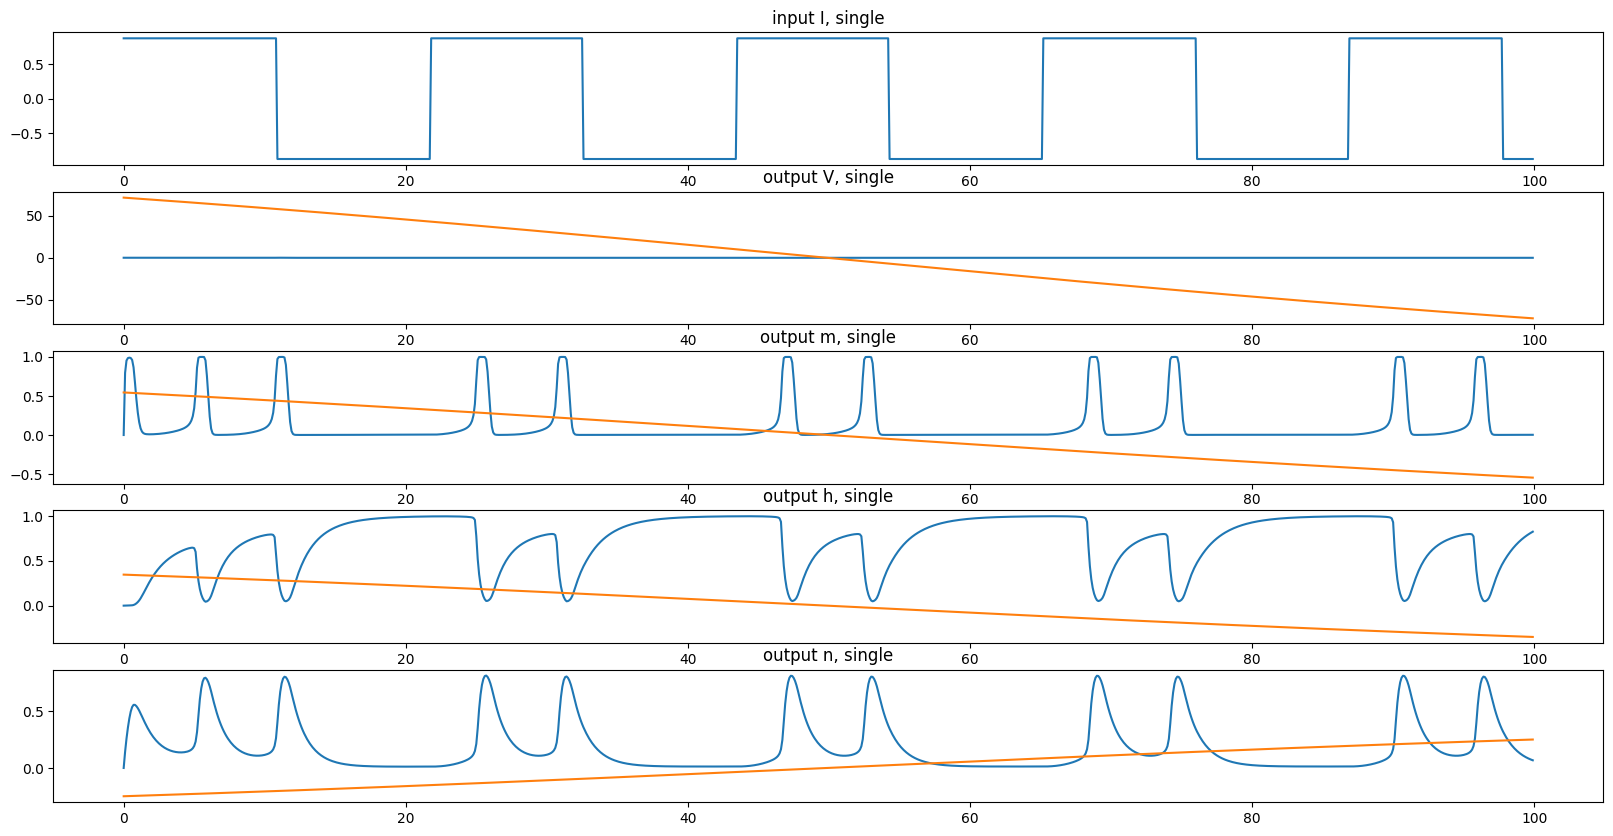

time: 2.63 s (started: 2023-09-11 09:38:18 +00:00)


In [ ]:
#@title Sample input/output of the model with true response
from copy import copy
v_single, m_single, n_single, h_single, i_single, t_single = calculate_HH_model_response(signal.square, 100)
print(i_single.shape)
print(t_single.shape)
print(X_train[:, 1:-1].shape)
print(X_train[:, :1].shape)
data = np.zeros((1000, 1001))
for i in range(1000):
  data[i, :-1] = i_single[:]
  data[i, -1] = t_single[i]

print(data.shape)
print(data[:, :-1].shape)
print(data[:, -1].shape)
preds = PI_DeepONet.predict({"forcing": tf.convert_to_tensor(data[:, :-1], dtype=tf.float32), "time": tf.convert_to_tensor(np.expand_dims(data[:, -1], 1), dtype=tf.float32)})
preds = np.array(preds)
print(preds.shape)

v_pred = preds[0, :, :].flatten()
m_pred = preds[1, :, :].flatten()
h_pred = preds[2, :, :].flatten()
n_pred = preds[3, :, :].flatten()

plt.subplot(5, 1, 1)
plt.plot(t_single, i_single)
plt.title('input I, single')
plt.subplot(5, 1, 2)
plt.plot(t_single, v_single)
plt.plot(t_single, v_pred*100)
plt.title('output V, single')
plt.subplot(5, 1, 3)
plt.plot(t_single, m_single)
plt.plot(t_single, m_pred)
plt.title('output m, single')
plt.subplot(5, 1, 4)
plt.plot(t_single, h_single)
plt.plot(t_single, h_pred)
plt.title('output h, single')
plt.subplot(5, 1, 5)
plt.plot(t_single, n_single)
plt.plot(t_single, n_pred)
plt.title('output n, single')


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_test))
train_ds = train_ds.batch(col_batch_size)
y_pred = PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})
print(y_pred.shape)
print(np.mean(tf.keras.metrics.mean_squared_error(y_test, y_pred)))


(4, 10000, 4)
0.12082422
time: 702 ms (started: 2023-09-14 03:20:33 +00:00)


In [ ]:
PI_DeepONet({"forcing": X_test[1:1000, 1:-1], "time": X_test[1:1000, -1]})

<tf.Tensor: shape=(4, 999, 4), dtype=float32, numpy=
array([[[-0.01029133, -0.01028851, -0.01028733, -0.01028421],
        [ 0.18429306,  0.18429588,  0.18429706,  0.18430017],
        [-0.01029133, -0.01028851, -0.01028733, -0.01028421],
        ...,
        [ 0.29880244,  0.29880527,  0.29880643,  0.29880956],
        [-0.01029112, -0.0102883 , -0.01028712, -0.010284  ],
        [-0.01029112, -0.0102883 , -0.01028712, -0.010284  ]],

       [[ 0.06763012,  0.06763294,  0.06763411,  0.06763723],
        [-0.06144868, -0.06144586, -0.06144468, -0.06144156],
        [ 0.06763012,  0.06763294,  0.06763411,  0.06763723],
        ...,
        [ 0.00774136,  0.00774418,  0.00774536,  0.00774848],
        [ 0.06763008,  0.0676329 ,  0.06763408,  0.0676372 ],
        [ 0.06763008,  0.0676329 ,  0.06763408,  0.0676372 ]],

       [[-0.02817373, -0.02817091, -0.02816973, -0.02816661],
        [ 0.06351335,  0.06351617,  0.06351735,  0.06352047],
        [-0.02817373, -0.02817091, -0.02816973, -

time: 110 ms (started: 2023-09-14 03:29:55 +00:00)


In [ ]:
PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})
PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})
PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})
PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})
PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})
PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})
PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})
PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})
PI_DeepONet({"forcing": X_test[:, 1:-1], "time": X_test[:, -1]})

<tf.Tensor: shape=(4, 10000, 4), dtype=float32, numpy=
array([[[-0.01029133, -0.01028851, -0.01028733, -0.01028421],
        [-0.01029133, -0.01028851, -0.01028733, -0.01028421],
        [ 0.18429306,  0.18429588,  0.18429706,  0.18430017],
        ...,
        [-0.01029133, -0.01028851, -0.01028733, -0.01028421],
        [-0.39528197, -0.39527914, -0.39527798, -0.39527485],
        [-0.01029133, -0.01028851, -0.01028733, -0.01028421]],

       [[ 0.06763012,  0.06763294,  0.06763411,  0.06763723],
        [ 0.06763012,  0.06763294,  0.06763411,  0.06763723],
        [-0.06144868, -0.06144586, -0.06144468, -0.06144156],
        ...,
        [ 0.06763012,  0.06763294,  0.06763411,  0.06763723],
        [-0.5362537 , -0.5362509 , -0.5362497 , -0.5362466 ],
        [ 0.06763012,  0.06763294,  0.06763411,  0.06763723]],

       [[-0.02817373, -0.02817091, -0.02816973, -0.02816661],
        [-0.02817373, -0.02817091, -0.02816973, -0.02816661],
        [ 0.06351335,  0.06351617,  0.06351735,

time: 2.65 s (started: 2023-09-14 03:31:01 +00:00)


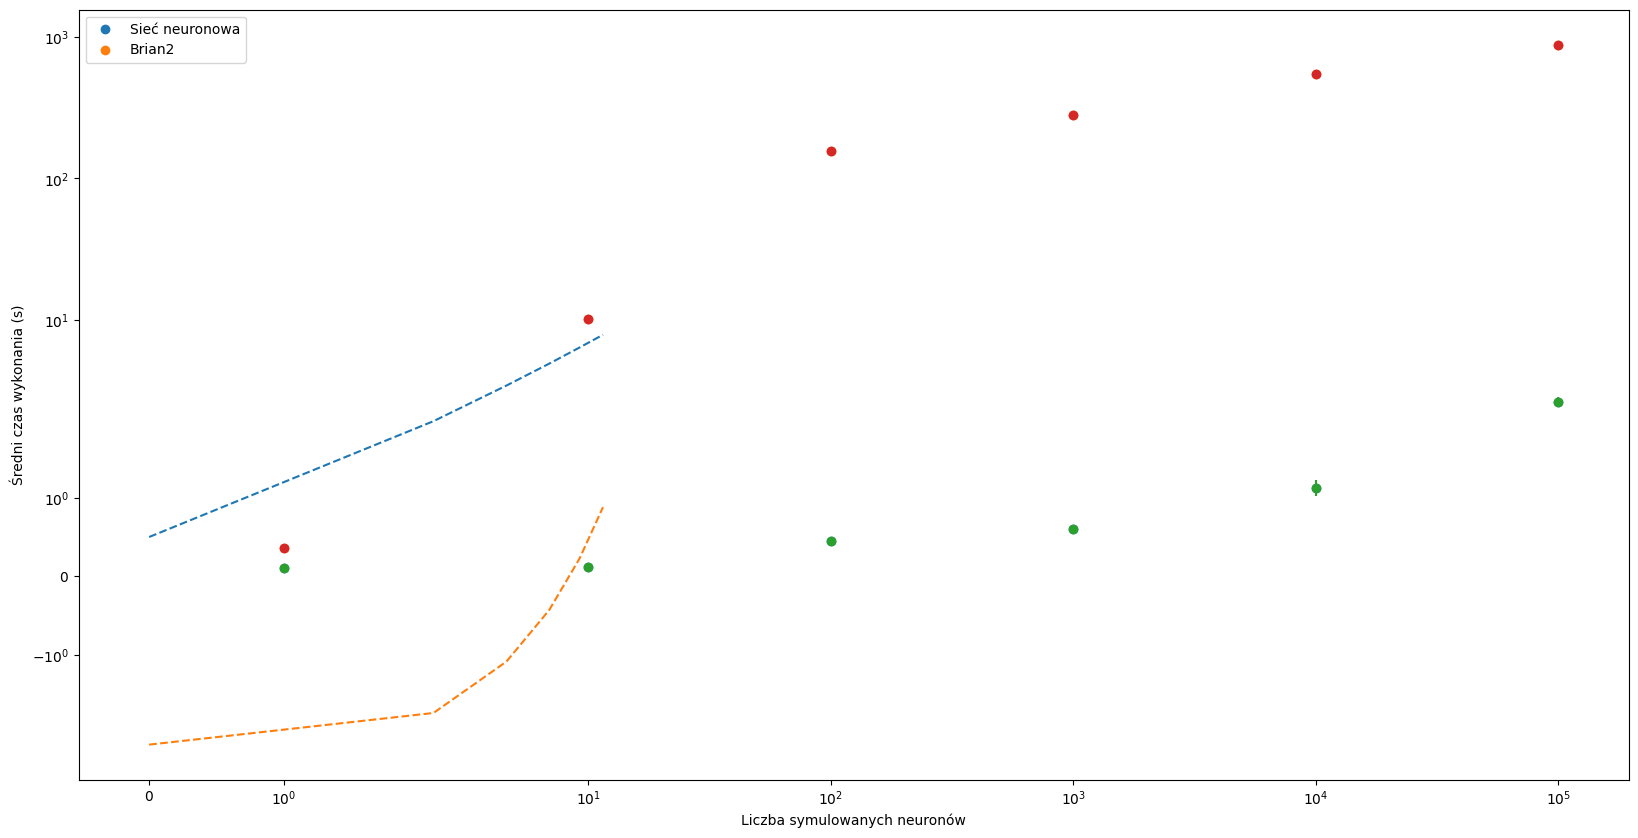

time: 1.95 s (started: 2023-09-21 12:48:17 +00:00)


In [ ]:
brian = [0.364, 10.1, 156.6, 280.2, 550.5, 880.2]
siec = [110*0.001, 120*0.001, 454*0.001, 600*0.001, 1120*0.001, 2650*0.001]
neurony = [1, 10, 100, 1000, 10000, 100000]
xerr = [0, 0, 0, 0, 0, 0]
yerrb = [0.009, 0.02, 0.11, 0.2, 0.33, 0.35]
yerrs = [0.008, 0.005, 0.01, 0.044, 0.1, 0.22]

p1 = np.polyfit(np.log(neurony), np.log(brian), deg=1)
p2 = np.polyfit(np.log(neurony), np.log(siec), deg=1)
y1 = p1[1] + p1[0] * np.log(neurony)
y2 = p2[1] + p2[0] * np.log(neurony)

#plt.plot(np.log(neurony), y1, '--')
#plt.plot(np.log(neurony), y2, '--')


plt.scatter(neurony, siec, label="Sieć neuronowa")
plt.scatter(neurony, brian, label="Brian2")
plt.errorbar(neurony, siec, yerr=yerrs, fmt="o")
plt.errorbar(neurony, brian, yerr=yerrb, fmt="o")
plt.xlabel('Liczba symulowanych neuronów')
plt.ylabel('Średni czas wykonania (s)')
plt.xscale('symlog')
plt.yscale('symlog')
plt.legend()
plt.savefig('wydajnosc.png')

In [ ]:
X_test2, y_test2, t_test2 = generate_dataset(100, 100, 100)

time: 3min 43s (started: 2023-09-14 03:32:15 +00:00)


In [ ]:
X_test2, y_test2, t_test2 = generate_dataset(10, 100, 100)

time: 14.9 s (started: 2023-09-14 03:36:16 +00:00)
